# Training du RNN pour le captioning

# Intro

blablabla

# préparation de l'environnement

In [1]:
#imports
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

import tensorboard
import datetime

import cv2

In [2]:
#Setting gpu for limit memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to only allocate 6gb of memory on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9144)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Chargement des données

In [3]:
# Chemin du fichier d'annotations
annotation_folder = "/annotations/"
annotation_file = os.path.abspath('.')+"/annotations/captions_train2014.json"

# Chemin du dossier contenant les images à annoter
#On va prendre des images pré débruité par le modele du livrable 2 pour l'entrainement.
image_folder = '/denoised_train2014/'
PATH = os.path.abspath('.') + image_folder

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = '<start> ' + val['caption'] + ' <end>' #A COMPLETER
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption) #A COMPLETER
    
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []


print(len(train_image_paths))

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list) #A COMPLETER
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list)) #A COMPLETER
    #print(len(caption_list))

print(train_captions)

print(len(img_name_vector))


2000
['<start> A very clean and well decorated empty bathroom <end>', '<start> A blue and white bathroom with butterfly themed wall tiles. <end>', '<start> A bathroom with a border of butterflies and blue paint on the walls above it. <end>', '<start> An angled view of a beautifully decorated bathroom. <end>', '<start> A clock that blends in with the wall hangs in a bathroom.  <end>', '<start> A panoramic view of a kitchen and all of its appliances. <end>', '<start> A panoramic photo of a kitchen and dining room <end>', '<start> A wide angle view of the kitchen work area <end>', '<start> multiple photos of a brown and white kitchen.  <end>', '<start> A kitchen that has a checkered patterned floor and white cabinets. <end>', '<start> A graffiti-ed stop sign across the street from a red car  <end>', '<start> A vandalized stop sign and a red beetle on the road <end>', '<start> A red stop sign with a Bush bumper sticker under the word stop. <end>', '<start> A stop sign that has been vandali

## Débruiteur
On entrera des images débruités dans notre CNN. Pour qu'il s'habitue a des images débruités

In [4]:
# #L2------
# model_denoising_path = "../Livrable_2/best_model/17_4_2024_17h12.keras"
# model_denoising = tf.keras.models.load_model(model_denoising_path)

# #L2
# def prepare_denoising(path):
#     img = cv2.imread(path)
#     img_correct_color = img
#     img_resized = cv2.resize(img_correct_color, (400,400))
#     img_normalized = img_resized.astype('float32') / 255.0
#     img_batch = np.expand_dims(img_normalized, axis=0)
#     return img_batch

In [5]:
# dossier = "denoised_train2014"
# for path in range(img_name_vector):
#     name = img_name_vector[path].split('/')[-1]
#     img = prepare_denoising(path)
#     img = model_denoising.predict(img)

#     cv2.imwrite(f'./{dossier}/{name}', img.squeeze()*255)




## Préparation d'inceptionV3

Au début, le modèle InceptionV3 est téléchargé sans la couche supérieure (qui est la couche de classification) et avec des poids pré-entraînés sur ImageNet. Une nouvelle couche d'entrée est créée avec la forme (299,299,3), qui est la forme d'entrée attendue par InceptionV3. La dernière couche cachée du modèle, qui contient la représentation compacte de l'image, est récupérée. Un nouveau modèle, `image_features_extract_model`, est ensuite créé avec la nouvelle entrée et la dernière couche cachée du modèle InceptionV3.

Ensuite, une fonction `load_image` est définie. Cette fonction prend un chemin d'image en entrée et renvoie un tuple contenant l'image traitée et son chemin. Les étapes de traitement de l'image comprennent le chargement du fichier image, le décodage de l'image en RGB, le redimensionnement de l'image à (299, 299), et la normalisation des pixels de l'image entre -1 et 1 en utilisant la fonction `preprocess_input` de InceptionV3.

Nous procédons ensuite au prétraitement des images. Il obtient d'abord les noms uniques des images de `img_name_vector` et les trie. Un jeu de données TensorFlow est créé à partir de ces noms d'images. La fonction `load_image` est ensuite appliquée à ce jeu de données en parallèle, et le jeu de données est divisé en lots de 16.

Nous iterrons ensuite sur chaque lot du jeu de données. Pour chaque lot, le `image_features_extract_model` est utilisé pour calculer les caractéristiques des images. Les caractéristiques sont ensuite remodelées de (16,8,8,2048) à (16,64,2048). Pour chaque image du lot, le chemin de l'image et les caractéristiques sont sauvegardés dans un fichier en utilisant `numpy.save`. Le chemin du fichier est le même que le chemin de l'image, et les caractéristiques sont sauvegardées dans le format binaire numpy. Ce processus est répété pour tous les lots dans le jeu de données.

In [6]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model =  tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuez le pre-traitement d'InceptionV3
print(image_dataset)
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

100%|██████████| 125/125 [00:19<00:00,  6.32it/s]


## Préparation du tokenizer

Le tokenizer va nous servir de dictionnaire. La bibliothèque Keras nous donne les mots les plus communs, nous avons choisi les 5000 premiers (voir la variable `top_k`). On crée ensuite le dictionnaire avec la méthode `fit_on_texts`, il sera basé sur les annotations du dataset Coco train 2014 et attribuera un token (un id entre 1 et 5000) à chaque mot.
Ainsi, notre RNN nous renverra un vecteur de tokens que nous traduirons en mots à la fin.

In [7]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] =  0
tokenizer.index_word[0] =  '<pad>'

# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs =  tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur à jusqu'à la longueur maximale des annotations
cap_vector =   tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)


## Split test/train

Nous créons les jeux d'entraînement et de test, pour les photos ainsi que les annotations.
Nous affichons leur longueur pour s'assurer de la bonne exécution de la fonction.

In [8]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)



len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(8004, 8004, 2001, 2001)

# Entrainement

## Définition des paramètres

In [9]:
# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 6000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Encodeur CNN
sortie d'inceptionV3 blablabla

In [10]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

## Décodeur RNN
blabla intro RNN
### Mécanisme d'attention
blabla badhanau

In [11]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)

        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

       # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
                    #(BATCH_SIZE,64,hidden_size) + (BATCH_SIZE,1,hidden_size)


        # attention_weights shape == (batch_size, 64, 1)
        # You get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)


        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        
        return context_vector, attention_weights

### Décodeur
blabla décodeur, gru etc

In [12]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
#A COMPLETER

        self.attention = BahdanauAttention(self.units)
#A COMPLETER

    def call(self, x, features, hidden):
        # L'attention est defini par un modèle a part
        context_vector, attention_weights = self.attention(features, hidden)
        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
#A COMPLETER
        # Concaténation
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
#A COMPLETER

        # Passage du vecteur concaténé à la gru
        output, state = self.gru(x)
#A COMPLETER
        
        y = tf.reshape(output, (-1, x.shape[2]))

        # Couche dense
        y = x = self.fc1(y)
#A COMPLETER

        
        
        # Couche dense
        y = self.fc2(x)
#A COMPLETER
        
        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

## Combinaison encodeur + décodeur

In [13]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
#A COMPLETER
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

## Prepare training loop
### Optimizer and Loss
blabla

In [14]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam(0.001)
#A COMPLETER
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Callbacks
blabla callbacks

In [15]:

#CALLBACKS


def get_val_loss(dataset, encoder, decoder):
    total_loss = 0
    for (batch,(img_tensor, target)) in enumerate(dataset):
        loss = 0
        # Initialisation de l'état caché pour chaque batch
        hidden = decoder.reset_state(batch_size=target.shape[0])
        #print(tokenizer.word_index)

        # Initialiser l'entrée du décodeur
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

        t_loss = (loss / int(target.shape[1]))

    
        total_loss += t_loss

    return total_loss
    


class Callbacker():
    def __init__(self, tensorboard = True, early_stopping = True, es_patience = 0, save_model = True):

        time = datetime.datetime.now()
        self.training_name = f"{time.day}_{time.month}_{time.year}_{time.hour}h{time.minute}"
        #self.best_loss = np.Inf
        self.best_val_loss = np.Inf
        self.wait = 0
        self.stopped_epoch = 0


        self.btensorboard = tensorboard
        self.bearly_stopping = early_stopping
        self.es_patience = es_patience
        self.save_model = save_model

        self.stop_training = False

        if self.btensorboard == True:
            self.writer= tf.summary.create_file_writer(f"tensorboard/{self.training_name}")


    def epoch_callback(self, encoder_model, decoder_model, num_epoch:int, current_loss:float, current_val_loss:float):
        """
        at each epoch, this function will be launched, we will record our weights and save our model if we have the best result since the beeginning of the training.
        this function need as parameters:
        - encoder model: the encoder model (usually RNN).
        - decoder: the decoder model (usually RNN)
        - num epoch : the current epoch number
        - current loss : the current train loss
        - current_val_loss : the current loss for validation
        """
        print(f"The average loss for epoch {num_epoch} is loss :{current_loss}, val loss : {current_val_loss}")

        if self.btensorboard == True:
            with self.writer.as_default():
                tf.summary.scalar('loss', current_loss, step=num_epoch)
                tf.summary.scalar('val_loss', current_val_loss, step=num_epoch)

        if np.less(current_val_loss, self.best_val_loss):
            #self.best_loss = current_loss
            self.best_val_loss = current_val_loss
            self.wait = 0
            self.encoder_best_weights = encoder_model.get_weights()
            self.decoder_best_weights = decoder_model.get_weights()
            # Record the best weights if current results is better (less).
            if self.save_model == True:
                encoder_model.save(f'./models/{self.training_name}/encoder.tf')
                decoder_model.save(f'./models/{self.training_name}/decoder.tf')
        else:
            if self.bearly_stopping == True:
                self.wait += 1
                if self.wait >= self.es_patience:
                    self.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    encoder_model.set_weights(self.encoder_best_weights)
                    decoder_model.set_weights(self.decoder_best_weights)
        


### Training step function
blabla backpropagation

In [17]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    #print(tokenizer.word_index)

    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        

        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

# Training
blabla train

In [18]:
EPOCHS = 30

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
val_dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
val_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



callbacker = Callbacker(es_patience= 3)

#create the directory
os.makedirs(f'./models/{callbacker.training_name}')
#save of the tokenizer
with open(f'./models/{callbacker.training_name}/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    #VALIDATION-------------------------------------------------------
    val_loss = get_val_loss(val_dataset,encoder,decoder)
    #------------------------------------------------------------------        
    
    #CALLBACK --------------------------------------------------------
    callbacker.epoch_callback(encoder, decoder, epoch, total_loss/num_steps, val_loss/num_steps)
    #-----------------------------------------------------------------
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Epoch 1 Batch 0 Loss 2.9551
Epoch 1 Batch 100 Loss 1.4537


# display the trained model's results
Fonctions:

In [19]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Reshape predictions to be a 2D matrix of shape [batch_size, vocab_size]
        predictions = tf.reshape(predictions, [1, -1])

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Affichage

d:\CESI\A5\datascience\Projet\DataScience\Livrable_3/train2014/COCO_train2014_000000495122.jpg
Real Caption: <start> a very large kitchen with all white cabinets and counter tops <end>
Prediction Caption: a refrigerator and some cabinets in a refrigerator standing next to a refrigerator and a refrigerator <end>


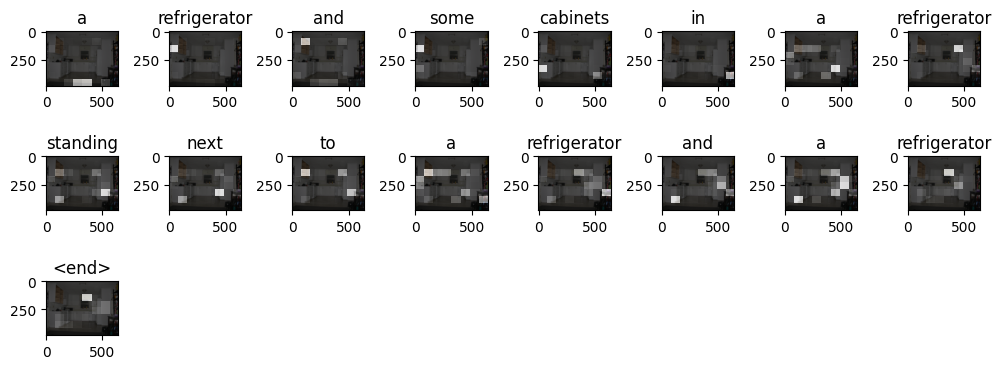

In [23]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# Sélection du meilleur modèle
Blabla grosse section à faire